In [1]:
import shutil

# Define source and destination paths
source_path = "/kaggle/input/eatformer21/"
destination_path = "/kaggle/working/"

# List of files to transfer
files_to_transfer = [
    "eatformer_binary_classification.pth",
    "losses.json",
    "optimizer_state.pth",
    "scheduler_state.pth"
]

# Transfer each file
for file_name in files_to_transfer:
    shutil.copy(f"{source_path}{file_name}", destination_path)
    print(f"Transferred {file_name} to {destination_path}")


Transferred eatformer_binary_classification.pth to /kaggle/working/
Transferred losses.json to /kaggle/working/
Transferred optimizer_state.pth to /kaggle/working/
Transferred scheduler_state.pth to /kaggle/working/


In [2]:
!pip install timm==0.6.5
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.8/512.8 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.9
    Uninstalling timm-1.0.9:
      Successfully uninstalled timm-1.0.9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.3 MB/s eta 0:00:00


In [3]:
import math
from functools import partial

from einops import rearrange, reduce, repeat
# from mmcv.ops import DeformConv2d
from torchvision.ops import DeformConv2d
import torch.nn.functional as F
from timm.models.layers.activations import *
from timm.models.layers import DropPath, trunc_normal_

init_alpha_value = 1e-3
init_scale_values = 1e-4


# ========== For Common ==========
class LayerNormConv(nn.Module):
	
	def __init__(self, normalized_shape, eps=1e-6, elementwise_affine=True):
		super().__init__()
		self.norm = nn.LayerNorm(normalized_shape, eps, elementwise_affine)
	
	def forward(self, x):
		x = rearrange(x, 'b c h w -> b h w c').contiguous()
		x = self.norm(x)
		x = rearrange(x, 'b h w c -> b c h w').contiguous()
		return x


def get_norm(norm_layer='in_1d'):
	eps = 1e-6
	norm_dict = {
		'none': nn.Identity,
		'in_1d': partial(nn.InstanceNorm1d, eps=eps),
		'in_2d': partial(nn.InstanceNorm2d, eps=eps),
		'in_3d': partial(nn.InstanceNorm3d, eps=eps),
		'bn_1d': partial(nn.BatchNorm1d, eps=eps),
		'bn_2d': partial(nn.BatchNorm2d, eps=eps),
		# 'bn_2d': partial(nn.SyncBatchNorm, eps=eps),
		'bn_3d': partial(nn.BatchNorm3d, eps=eps),
		'gn': partial(nn.GroupNorm, eps=eps),
		'ln': partial(nn.LayerNorm, eps=eps),
		'lnc': partial(LayerNormConv, eps=eps),
	}
	return norm_dict[norm_layer]


def get_act(act_layer='relu'):
	act_dict = {
		'none': nn.Identity,
		'sigmoid': Sigmoid,
		'swish': Swish,
		'mish': Mish,
		'hsigmoid': HardSigmoid,
		'hswish': HardSwish,
		'hmish': HardMish,
		'tanh': Tanh,
		'relu': nn.ReLU,
		'relu6': nn.ReLU6,
		'prelu': PReLU,
		'gelu': GELU,
		'silu': nn.SiLU
	}
	return act_dict[act_layer]


# ========== Individual ==========
class MLP(nn.Module):
	
	def __init__(self, in_dim, hid_dim=None, out_dim=None, act_layer='gelu', drop=0.):
		super().__init__()
		out_dim = out_dim or in_dim
		hid_dim = hid_dim or in_dim
		self.fc1 = nn.Conv2d(in_dim, hid_dim, kernel_size=1, stride=1, padding=0)
		self.act = get_act(act_layer)()
		self.fc2 = nn.Conv2d(hid_dim, out_dim, kernel_size=1, stride=1, padding=0)
		self.drop = nn.Dropout(drop)
	
	def forward(self, x):
		x = self.fc1(x)
		x = self.act(x)
		x = self.drop(x)
		x = self.fc2(x)
		x = self.drop(x)
		return x


class FFN(nn.Module):
	
	def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer='gelu', norm_layer='lnc'):
		super().__init__()
		self.norm = get_norm(norm_layer)(dim)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		hid_dim = int(dim * mlp_ratio)
		self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
		self.gamma_mlp = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		shortcut = x
		x = self.norm(x)
		x = shortcut + self.drop_path(self.gamma_mlp.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mlp(x))
		return x


# ========== Global and Local Populations ==========
class MSA(nn.Module):
	def __init__(self, dim, dim_head, qkv_bias=False, attn_drop=0., proj_drop=0.):
		super().__init__()
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		
		self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0)
		self.proj_drop = nn.Dropout(proj_drop)
	
	def forward(self, x):
		B, C, H, W = x.shape
		
		qkv = self.qkv(x)
		qkv = rearrange(qkv, 'b (qkv heads dim_head) h w -> qkv b heads (h w) dim_head', qkv=3, heads=self.num_head, dim_head=self.dim_head).contiguous()
		q, k, v = qkv[0], qkv[1], qkv[2]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head, dim_head=self.dim_head, h=H, w=W).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class MSA_OP(nn.Module):
	
	def __init__(self, dim, dim_head, window_size, qkv_bias=False, attn_drop=0., proj_drop=0., init_scale_values=1e-4):
		super().__init__()
		assert dim % dim_head == 0
		self.window_size = window_size
		self.msa = MSA(dim, dim_head, qkv_bias, attn_drop, proj_drop)
		self.gamma_msa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		B, C, H, W = x.shape
		if self.window_size <= 0:
			window_size_W, window_size_H = W, H
		else:
			window_size_W, window_size_H = self.window_size, self.window_size
		pad_l, pad_t = 0, 0
		pad_r = (window_size_W - W % window_size_W) % window_size_W
		pad_b = (window_size_H - H % window_size_H) % window_size_H
		x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))
		
		n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
		x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
		x = self.gamma_msa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.msa(x)
		x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()
		
		if pad_r > 0 or pad_b > 0:
			x = x[:, :, :H, :W].contiguous()
			
		return x
	
	
class DMSA(nn.Module):
	def __init__(self, dim, dim_head, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
		super().__init__()
		assert dim % dim_head == 0
		self.kernel_size = kernel_size
		self.stride = stride
		self.dim = dim
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		self.d_groups = d_groups
		self.n_group_dim = self.dim // self.d_groups
		self.offset_range_factor = 2
		
		self.conv_offset_modulation = nn.Sequential(
			nn.Conv2d(self.n_group_dim, self.n_group_dim, self.kernel_size, self.stride, self.kernel_size // 2, groups=self.n_group_dim),
			get_norm('bn_2d')(self.n_group_dim),
			nn.GELU(),
			nn.Conv2d(self.n_group_dim, 3, 1, 1, 0, bias=False)
		)
		self.modulation_act = get_act('sigmoid')()
		self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, bias=True)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj_drop = nn.Dropout(proj_drop)
	
	@torch.no_grad()
	def _get_ref_points(self, H, W, B, dtype, device):
		ref_y, ref_x = torch.meshgrid(torch.linspace(0.5, H - 0.5, H, dtype=dtype, device=device),
									  torch.linspace(0.5, W - 0.5, W, dtype=dtype, device=device))
		ref = torch.stack((ref_y, ref_x), -1)
		ref[..., 1].div_(W).mul_(2).sub_(1)
		ref[..., 0].div_(H).mul_(2).sub_(1)
		ref = ref[None, ...].expand(B * self.d_groups, -1, -1, -1)  # B * g H W 2
		return ref
	
	def forward(self, x):
		B, C, H, W = x.shape
		q = self.q(x)
		q_off = rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.d_groups, c=self.n_group_dim).contiguous()
		offset_modulation = self.conv_offset_modulation(q_off)  # bg 3 h w
		offset, modulation = offset_modulation[:, 0:2, :, :], self.modulation_act(offset_modulation[:, 2:3, :, :])  # bg 2 h w, bg 1 h w
		H_off, W_off = offset.size(2), offset.size(3)
		
		offset_range = torch.tensor([1.0 / H_off, 1.0 / W_off], device=x.device).reshape(1, 2, 1, 1)
		offset = offset.tanh().mul(offset_range).mul(self.offset_range_factor)
		offset = rearrange(offset, 'b c h w -> b h w c').contiguous()
		reference = self._get_ref_points(H_off, W_off, B, x.dtype, x.device)
		pos = offset + reference
		
		x_sampled = F.grid_sample(input=x.reshape(B * self.d_groups, self.n_group_dim, H, W),
								  grid=pos[..., (1, 0)],  # y, x -> x, y
								  mode='bilinear', align_corners=True)  # B * g, Cg, Hg, Wg
		x_sampled *= modulation.sigmoid()
		x_sampled = rearrange(x_sampled, '(b g) c h w -> b (g c) h w', b=B, g=self.d_groups).contiguous()
		q = rearrange(q, 'b (heads dim_head) h w -> b heads (h w) dim_head', heads=self.num_head,
					  dim_head=self.dim_head).contiguous()
		kv = self.kv(x_sampled)
		kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
					   dim_head=self.dim_head).contiguous()
		k, v = kv[0], kv[1]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
					  dim_head=self.dim_head, h=H, w=W).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class DMSA_OP(nn.Module):
	
	def __init__(self, dim, dim_head, window_size, kernel_size, stride, qkv_bias=False, attn_drop=0., proj_drop=0., d_groups=3):
		super().__init__()
		self.window_size = window_size
		self.mdmsa = DMSA(dim, dim_head, kernel_size, stride, qkv_bias, attn_drop, proj_drop, d_groups)
		self.gamma_mdmsa = nn.Parameter(init_scale_values * torch.ones((dim)), requires_grad=True)
	
	def forward(self, x):
		B, C, H, W = x.shape
		if self.window_size <= 0:
			window_size_W, window_size_H = W, H
		else:
			window_size_W, window_size_H = self.window_size, self.window_size
		pad_l, pad_t = 0, 0
		pad_r = (window_size_W - W % window_size_W) % window_size_W
		pad_b = (window_size_H - H % window_size_H) % window_size_H
		x = F.pad(x, (pad_l, pad_r, pad_t, pad_b, 0, 0,))
		
		n1, n2 = (H + pad_b) // window_size_H, (W + pad_r) // window_size_W
		x = rearrange(x, 'b c (h1 n1) (w1 n2) -> (b n1 n2) c h1 w1', n1=n1, n2=n2).contiguous()
		x = self.gamma_mdmsa.unsqueeze(0).unsqueeze(2).unsqueeze(3) * self.mdmsa(x)
		x = rearrange(x, '(b n1 n2) c h1 w1 -> b c (h1 n1) (w1 n2)', n1=n1, n2=n2).contiguous()
		
		if pad_r > 0 or pad_b > 0:
			x = x[:, :, :H, :W].contiguous()
		return x


class Conv_OP(nn.Module):
	
	def __init__(self, dim, kernel_size, stride=1):
		super().__init__()
		padding = math.ceil((kernel_size - stride) / 2)
		self.conv1 = nn.Conv2d(dim, dim, kernel_size, stride, padding, groups=dim)
		self.norm1 = get_norm('bn_2d')(dim)
		self.act1 = get_act('silu')()
		self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
		
	def forward(self, x):
		x = self.conv1(x)
		x = self.norm1(x)
		x = self.act1(x)
		x = self.conv2(x)
		return x


class DCN2_OP(nn.Module):
	# ref: https://github.com/WenmuZhou/DBNet.pytorch/blob/678b2ae55e018c6c16d5ac182558517a154a91ed/models/backbone/resnet.py
	def __init__(self, dim, kernel_size=3, stride=1, deform_groups=4):
		super().__init__()
		offset_channels = kernel_size * kernel_size * 2
		self.conv1_offset = nn.Conv2d(dim, deform_groups * offset_channels, kernel_size=3, stride=stride, padding=1)
		self.conv1 = DeformConv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
		self.norm1 = get_norm('bn_2d')(dim)
		self.act1 = get_act('silu')()
		self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
		
	def forward(self, x):
		offset = self.conv1_offset(x)
		x = self.conv1(x, offset)
		x = self.norm1(x)
		x = self.act1(x)
		x = self.conv2(x)
		return x


class GLI(nn.Module):
	
	def __init__(self, in_dim, dim_head, window_size, kernel_size=5, qkv_bias=False, drop=0., attn_drop=0.,
				 drop_path=0., act_layer='gelu', norm_layer='bn_2d',
				 op_names=['msa', 'mdmsa', 'conv', 'dcn'], d_group=3, gli_split=False, gli_weight=True, gli_ratio=None):
		super().__init__()
		self.op_names = op_names
		self.gli_split = gli_split
		self.gli_weight = gli_weight
		self.gli_ratio = gli_ratio
		self.op_num = len(op_names)
		self.norm = get_norm(norm_layer)(in_dim)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		if self.op_num == 1:
			dims = [in_dim]
		else:
			if gli_split:
				if gli_ratio:
					assert self.op_num == 2
					dims = [int(in_dim * gli_ratio), round(in_dim * (1 - gli_ratio))]
				else:
					dim = in_dim // self.op_num
					assert dim * self.op_num == in_dim
					dims = [dim] * self.op_num
			else:
				dims = [in_dim] * self.op_num
		self.dims = dims
		self.ops = nn.ModuleList()
		for idx, op_name in enumerate(op_names):
			if op_name in ['conv', 'c']:
				op = Conv_OP(dims[idx], kernel_size, stride=1)
			elif op_name in ['dcn', 'dc']:
				op = DCN2_OP(dims[idx], kernel_size, stride=1, deform_groups=d_group)
			elif op_name in ['msa', 'm']:
				op = MSA_OP(dims[idx], dim_head, window_size, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
			elif op_name in ['mdmsa', 'dm']:
				op = DMSA_OP(dims[idx], dim_head, window_size, kernel_size=5, stride=1, qkv_bias=True, attn_drop=attn_drop, proj_drop=drop, d_groups=d_group)
			else:
				raise 'invalid \'{}\' operation'.format(op_name)
			self.ops.append(op)
		if self.op_num > 1 and gli_weight:
			self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.op_num), requires_grad=True)
	
	def forward(self, x):
		shortcut = x
		x = self.norm(x)
		if self.op_num == 1:
			x = self.ops[0](x)
		else:
			if self.gli_split:
				if self.gli_ratio:
					xs = [x[:, :self.dims[0], :, :], x[:, self.dims[0]:, :, :]]
				else:
					xs = torch.chunk(x, self.op_num, dim=1)
			else:
				xs = [x] * self.op_num
			if self.gli_weight:
				alphas = F.softmax(self.alphas, dim=-1)
				if self.gli_split:
					if self.gli_ratio:
						x = torch.cat([self.ops[i](xs[i]) * alphas[i] for i in range(self.op_num)], dim=1).contiguous()
					else:
						xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
						x = rearrange(xs, 'b c h w n -> b (c n) h w').contiguous()
				else:
					xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) * alphas[i] for i in range(self.op_num)], dim=-1)
					x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
			else:
				if self.gli_split:
					x = torch.cat([self.ops[i](xs[i]) for i in range(self.op_num)], dim=1)
				else:
					xs = torch.cat([self.ops[i](xs[i]).unsqueeze(dim=-1) for i in range(self.op_num)], dim=-1)
					x = reduce(xs, 'b c h w n -> b c h w', 'mean').contiguous()
		x = shortcut + self.drop_path(x)
		return x


# ========== Multi-Scale Populations ==========
class MSP(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
				 act_layer='silu', norm_layer='bn_2d', msra_weight=True):
		super().__init__()
		self.msra_mode = msra_mode
		self.msra_weight = msra_weight
		self.dilation_num = len(dilations)
		assert in_dim % c_group == 0
		c_group = (in_dim if c_group == -1 else c_group) if stride == 1 else 1
		self.convs = nn.ModuleList()
		for i in range(len(dilations)):
			padding = math.ceil(((kernel_size - 1) * dilations[i] + 1 - stride) / 2)
			self.convs.append(nn.Sequential(
				nn.Conv2d(in_dim, emb_dim, kernel_size, stride, padding, dilations[i], groups=c_group),
				get_act(act_layer)(emb_dim)))
		if self.dilation_num > 1 and msra_weight:
			self.alphas = nn.Parameter(init_alpha_value * torch.ones(self.dilation_num), requires_grad=True)
		self.conv_out = nn.Conv2d(emb_dim * (self.dilation_num if msra_mode == 'cat' else 1), emb_dim, kernel_size=1, stride=1, padding=0, bias=False)
	
	def forward(self, x):
		# B, C, H, W
		if self.dilation_num == 1:
			x = self.convs[0](x)
		else:
			if self.msra_weight:
				alphas = F.softmax(self.alphas, dim=-1)
				x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) * alphas[i] for i in range(self.dilation_num)], dim=-1)
			else:
				x = torch.cat([self.convs[i](x).unsqueeze(dim=-1) for i in range(self.dilation_num)], dim=-1)
			if self.msra_mode == 'cat':
				x = rearrange(x, 'b c h w n -> b (c n) h w').contiguous()
			elif self.msra_mode == 'sum':
				x = reduce(x, 'b c h w n -> b c h w', 'mean').contiguous()
		x = self.conv_out(x)
		return x


class MSRA(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, c_group=-1, stride=1, dilations=[1, 2, 3], msra_mode='cat',
				 act_layer='silu', norm_layer='bn_2d', msra_weight=True, msra_norm=True, msra_skip=True, drop_path=0.):
		super().__init__()
		self.norm = get_norm(norm_layer)(in_dim) if msra_norm else nn.Identity()
		self.msp = MSP(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, act_layer, norm_layer, msra_weight)
		self.msra_skip = msra_skip
		if msra_skip:
			if stride == 1:
				self.skip_conv = nn.Identity()
			else:
				self.skip_conv = nn.Sequential(nn.AvgPool2d(kernel_size=stride, stride=stride, ceil_mode=True, count_include_pad=False),
											   nn.Conv2d(in_dim, emb_dim, 1, stride=1, padding=0, bias=False),
											   get_norm(norm_layer)(emb_dim))
			self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
	
	def forward(self, x):
		shortcut = x
		x = self.msp(self.norm(x))
		if self.msra_skip:
			x = self.skip_conv(shortcut) + self.drop_path(x)
		return x


# ========== Block ==========
class EATBlock(nn.Module):
	
	def __init__(self, in_dim, emb_dim, kernel_size=3, stride=1, dilations=[1, 2, 3], norms=['bn_2d', 'bn_2d', 'bn_2d'],
				 msra_mode='cat', msra_weight=True, msra_norm=True, msra_skip=True,
				 dim_head=6, window_size=7, qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
				 op_names=['msa', 'conv'], d_group=3, c_group=-1, gli_split=False, gli_weight=True, gli_ratio=None, mlp_ratio=4., ):
		super().__init__()
		self.layer1 = MSRA(in_dim, emb_dim, kernel_size, c_group, stride, dilations, msra_mode, 'silu', norms[0],
									msra_weight, msra_norm, msra_skip, drop_path)
		self.layer2 = GLI(emb_dim, dim_head, window_size, 5, qkv_bias,
								   drop, attn_drop, drop_path, 'silu', norms[1],
								   op_names, d_group, gli_split, gli_weight, gli_ratio)
		self.layer3 = FFN(emb_dim, mlp_ratio, drop, drop_path, 'gelu', norms[2])
	
	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		return x


# ========== Task-related Head ==========
class MCA(nn.Module):
	def __init__(self, dim, dim_head=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
		super().__init__()
		self.dim_head = dim_head
		self.num_head = dim // dim_head
		self.scale = self.dim_head ** -0.5
		
		self.q = nn.Conv2d(dim, dim * 1, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.kv = nn.Conv2d(dim, dim * 2, kernel_size=1, stride=1, padding=0, bias=qkv_bias)
		self.attn_drop = nn.Dropout(attn_drop)
		self.proj = nn.Conv2d(dim, dim, kernel_size=1, stride=1, padding=0, )
		self.proj_drop = nn.Dropout(proj_drop)
	
	def forward(self, x, xq):
		B, C, H, W = x.shape
		_, _, Hq, Wq = xq.shape
		
		q = self.q(xq)
		kv = self.kv(x)
		q = rearrange(q, 'b (q heads dim_head) h w -> q b heads (h w) dim_head', q=1, heads=self.num_head,
					  dim_head=self.dim_head).contiguous()
		kv = rearrange(kv, 'b (kv heads dim_head) h w -> kv b heads (h w) dim_head', kv=2, heads=self.num_head,
					   dim_head=self.dim_head).contiguous()
		q, k, v = q[0], kv[0], kv[1]
		
		attn = (q @ k.transpose(-2, -1)) * self.scale
		attn = attn.softmax(dim=-1)
		attn = self.attn_drop(attn)
		
		x = attn @ v
		x = rearrange(x, 'b heads (h w) dim_head -> b (heads dim_head) h w', heads=self.num_head,
					  dim_head=self.dim_head, h=Hq, w=Wq).contiguous()
		x = self.proj(x)
		x = self.proj_drop(x)
		return x


class TRHead(nn.Module):
	
	def __init__(self, dim, dim_head, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
				 drop_path=0., act_layer='gelu', norm_layer='lnc'):
		super().__init__()
		self.norm_kv = get_norm(norm_layer)(dim)
		self.norm1 = get_norm(norm_layer)(dim)
		self.attn = MCA(dim, dim_head=dim_head, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
		self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
		self.norm2 = get_norm(norm_layer)(dim)
		hid_dim = int(dim * mlp_ratio)
		self.mlp = MLP(in_dim=dim, hid_dim=hid_dim, out_dim=dim, act_layer=act_layer, drop=drop)
	
	def forward(self, x, xq):
		xq = xq + self.drop_path(self.attn(self.norm_kv(x), self.norm1(xq)))
		xq = xq + self.drop_path(self.mlp(self.norm2(xq)))
		return xq


class HaarWaveletTransform(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HaarWaveletTransform, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Projection layer to match the number of channels if necessary
        if in_channels != out_channels:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.proj = nn.Identity()

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        batch_size, channels, height, width = x.size()

        # Ensure input dimensions are even
        if height % 2 != 0 or width % 2 != 0:
            pad_h = 1 if height % 2 != 0 else 0
            pad_w = 1 if width % 2 != 0 else 0
            x = nn.functional.pad(x, (0, pad_w, 0, pad_h))
            height += pad_h
            width += pad_w

        # Apply Haar wavelet transform on each channel
        transformed = []
        for c in range(channels):
            # Convert tensor to numpy
            img = x[:, c, :, :].cpu().detach().numpy()

            # Apply DWT2
            coeffs = pywt.dwt2(img, 'haar')
            LL, (LH, HL, HH) = coeffs

            # Compute the Haar feature (XRC_cap)
            XRC_cap = np.sqrt(LH**2 + HL**2 + HH**2)

            # Convert back to tensor
            XRC_cap_tensor = torch.tensor(XRC_cap, dtype=x.dtype).to(x.device)
            transformed.append(XRC_cap_tensor.unsqueeze(1))  # (batch, 1, H/2, W/2)

        # Stack all channels
        transformed = torch.cat(transformed, dim=1)  # (batch, channels, H/2, W/2)

        # Upsample to match original spatial dimensions
        transformed = nn.functional.interpolate(transformed, size=(height, width), mode='bilinear', align_corners=False)

        # Project to match output channels
        transformed = self.proj(transformed)

        return transformed

class EATFormer(nn.Module):
    
    def __init__(self, in_dim=3, num_classes=1000,
                 depths=[2, 2, 6, 2], embed_dims=[64, 128, 256, 512], dim_heads=[32, 32, 32, 32],
                 window_sizes=[7, 7, 7, 7], kernel_sizes=[3, 3, 3, 3], down_mode='kernel',
                 dilations=[[1], [1], [1, 2, 3], [1, 2]], norms=['bn_2d', 'bn_2d', 'bn_2d'],
                 msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
                 qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
                 d_groups=[3, 3, 3, 3], c_groups=[-1, -1, -1, -1], gli_split=False, gli_weight=True, gli_ratio=None,
                 mlp_ratio=4., cls_head_nums=0):
        super().__init__()
        self.num_classes = num_classes
        self.cls_head_nums = cls_head_nums
        dprs = [x.item() for x in torch.linspace(0, drop_path, sum(depths))]  # stochastic depth decay rule

        # Stage 0: Initial convolutional blocks
        self.stage0 = nn.ModuleList([
			MSRA(in_dim, embed_dims[0] // 2, kernel_size=3, c_group=1, stride=2, dilations=[1], msra_mode='sum',
						  act_layer='silu', norm_layer='bn_2d', msra_weight=False,
						  msra_norm=False, msra_skip=False),
			MSRA(embed_dims[0] // 2, embed_dims[0], kernel_size=3, c_group=1, stride=2, dilations=[1], msra_mode='sum',
						  act_layer='silu', norm_layer='bn_2d', msra_weight=False,
						  msra_norm=True, msra_skip=False)
        ])

        # Haar Wavelet Transform as Residual
        self.haar_residual = nn.Conv2d(3, 64, kernel_size=1)  # Haar transform to generate 64 channels

        
         # Initialize a convolution layer for adjusting haar_features size
        self.adjust_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)  # Adjust to 64 channels


        # Build stages (stage1, stage2, etc.)
        emb_dim_pre = embed_dims[0]
        for i in range(len(depths)):
            layers = []
            dpr = dprs[sum(depths[:i]):sum(depths[:i + 1])]
            for j in range(depths[i]):
                stride = 2 if j == 0 and i > 0 else 1
                kernel_size = stride if stride > 1 and down_mode == 'patch' else kernel_sizes[i]
                layers.append(EATBlock(emb_dim_pre, emb_dim=embed_dims[i], kernel_size=kernel_size, stride=stride,
                                      dilations=dilations[i], norms=norms, msra_mode=msra_mode, msra_weight=msra_weight, msra_norm=msra_norm,
                                      msra_skip=msra_skip, dim_head=dim_heads[i], window_size=window_sizes[i],
                                      qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=dpr[j],
                                      op_names=op_names[i], d_group=d_groups[i], c_group=c_groups[i],
                                      gli_split=gli_split, gli_weight=gli_weight, gli_ratio=gli_ratio, mlp_ratio=mlp_ratio,))
                emb_dim_pre = embed_dims[i]
            self.__setattr__(f'stage{i + 1}', nn.ModuleList(layers))

        # Classification head
        if cls_head_nums:
            self.cls_token = nn.Parameter(torch.zeros(1, embed_dims[-1], 1, 1))
            layers = [TRHead(embed_dims[-1], dim_heads[-1], mlp_ratio=mlp_ratio,
                             qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=0.)
                      for _ in range(cls_head_nums)]
            self.stage_cls = nn.ModuleList(layers)
        else:
            self.cls_token, self.stage_cls = None, nn.ModuleList()

        self.norm = nn.BatchNorm2d(embed_dims[-1])
        self.head = nn.Linear(embed_dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        
        if self.cls_token is not None:
            trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}
    
    def no_weight_decay_keywords(self):
        return {'alpha', 'gamma', 'beta'}
    
    def no_ft_keywords(self):
        return {}
    
    def ft_head_keywords(self):
        return {'head.weight', 'head.bias'}, self.num_classes
    
    def get_classifier(self):
        return self.head
    
    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
    
    def check_bn(self):
        for name, m in self.named_modules():
            if isinstance(m, torch.nn.modules.batchnorm._NormBase):
                m.running_mean.nan_to_num_(nan=0, posinf=1, neginf=-1)
                m.running_var.nan_to_num_(nan=0, posinf=1, neginf=-1)

    def adjust_haar_size(self, haar_features, target_size):
        # Resize the haar_features using an interpolation method or additional conv layer
        # Use the already initialized self.adjust_conv layer
        haar_features = self.adjust_conv(haar_features) 

        # Now ensure it matches the target size using interpolation
        if haar_features.size(2) != target_size[2] or haar_features.size(3) != target_size[3]:
            haar_features = nn.functional.interpolate(haar_features, size=(target_size[2], target_size[3]), mode='bilinear', align_corners=False)

        return haar_features
    
    def forward_features(self, x):
        # Apply Haar wavelet transform before stage0
        haar_features = self.haar_residual(x)

        # Pass through stage0 convolution blocks
        for blk in self.stage0:
            x = blk(x)

        # If needed, use a convolution to match sizes
        if haar_features.size() != x.size():
            haar_features = self.adjust_haar_size(haar_features, x.size())

        # Introduce learnable weight for combining Haar and original features
        alpha = nn.Parameter(torch.ones(1, device=x.device))  # Initialize alpha on the same device as x

        # Perform the weighted sum of x and haar_features
        x = alpha * x + (1 - alpha) * haar_features

        # Pass through remaining stages
        for blk in self.stage1:
            x = blk(x)
        for blk in self.stage2:
            x = blk(x)
        for blk in self.stage3:
            x = blk(x)
        for blk in self.stage4:
            x = blk(x)

        return x

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.forward_features(x)
        if self.cls_head_nums:
            cls_token = self.cls_token.expand(B, -1, -1, -1)
            for blk in self.stage_cls:
                cls_token = blk(x, cls_token)
            x = cls_token
            
        x = self.norm(x)
        x = reduce(x, 'b c h w -> b c', 'mean').contiguous()
        x = self.head(x)
        return x



def eatformer_mobile(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[1, 1, 4, 1], embed_dims=[48, 64, 160, 256], dim_heads=[16, 16, 20, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='patch', dilations=[[1], [1], [1, 2], [1]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.03,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=2.5, cls_head_nums=0, **kwargs)
	return model


def eatformer_lite(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[1, 2, 6, 1], embed_dims=[64, 128, 192, 256], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='patch', dilations=[[1], [1], [1, 2], [1]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.03,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=3, cls_head_nums=0, **kwargs)
	return model


def eatformer_tiny(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[2, 2, 6, 2], embed_dims=[64, 128, 192, 256], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.05,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_mini(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[2, 3, 8, 2], embed_dims=[64, 128, 256, 320], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.07,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_small(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[3, 4, 12, 3], embed_dims=[64, 128, 320, 448], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.10,
		op_names=[['conv'], ['conv'], ['mdmsa', 'conv'], ['mdmsa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_medium(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[4, 5, 14, 4], embed_dims=[64, 160, 384, 512], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.2,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model


def eatformer_base(pretrained=False, **kwargs):
	model = EATFormer(
		# in_dim=3, num_classes=1000,
		depths=[5, 6, 18, 5], embed_dims=[64, 160, 384, 512], dim_heads=[32, 32, 32, 32], window_sizes=[7, 7, 7, 7],
		kernel_sizes=[3, 3, 3, 3], down_mode='kernel', dilations=[[1], [1], [1, 2, 3], [1, 2]],
		norms=['bn_2d', 'bn_2d', 'bn_2d'], msra_mode='sum', msra_weight=True, msra_norm=True, msra_skip=True,
		qkv_bias=True, drop=0., attn_drop=0., drop_path=0.25,
		op_names=[['conv'], ['conv'], ['msa', 'conv'], ['msa', 'conv']],
		d_groups=[2, 2, 2, 2], c_groups=[-1, -1, -1, -1], gli_split=True, gli_weight=True,
		mlp_ratio=4., cls_head_nums=0, **kwargs)
	return model

In [4]:
import torchvision.models as models


class DualModel(nn.Module):
    def __init__(self, pretrained_eatformer=False, pretrained_resnet=True):
        super(DualModel, self).__init__()
        
        # EATFormer initialization
        self.eat_model = eatformer_base(pretrained=pretrained_eatformer)
        in_features_eat = self.eat_model.head.in_features
        self.eat_model.head = nn.Identity()  # Remove classification head
        
        # ResNet initialization
        self.resnet_model = models.resnet50(pretrained=pretrained_resnet)
        in_features_resnet = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Identity()  # Remove classification head
        
        # Combined classifier
        combined_features = in_features_eat + in_features_resnet
        self.head = nn.Linear(combined_features, 1)

    def forward(self, x):
        # Forward pass through EATFormer
        eat_features = self.eat_model(x)
        
        # Forward pass through ResNet
        resnet_features = self.resnet_model(x)
        
        # Concatenate features
        combined_features = torch.cat((eat_features, resnet_features), dim=1)
        
        # Classification head
        output = self.head(combined_features)
        return output


In [5]:
import os, json
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# ---------------------------
# 1) Dataset: Video → fixed‑len Seq of probs
# ---------------------------
class CelebDFSeqDataset(Dataset):
    def __init__(self, root_dir, split,
                 base_model, transform,
                 max_len=50):
        """
        root_dir/
          real/{video_id}/frame*.jpg
          fake/{video_id}/frame*.jpg
        split is unused here (Train vs Test folder passed separately).
        """
        self.real_dir = os.path.join(root_dir, "real")
        self.fake_dir = os.path.join(root_dir, "fake")

        # build (frame_paths_list, label) for each video
        self.videos = []
        for label, d in [(1, self.real_dir), (0, self.fake_dir)]:
            for vid in os.listdir(d):
                vid_dir = os.path.join(d, vid)
                if not os.path.isdir(vid_dir): continue
                frames = sorted([
                    os.path.join(vid_dir, f)
                    for f in os.listdir(vid_dir)
                    if f.lower().endswith(('.jpg','.png'))
                ])
                if not frames: continue
                self.videos.append((frames, label))

        self.base      = base_model.eval()
        self.dev       = next(self.base.parameters()).device
        self.transform = transform
        self.max_len   = max_len

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames, label = self.videos[idx]
        L = len(frames)

        # uniformly sample indices up to max_len
        if L > self.max_len:
            idxs = np.linspace(0, L-1, self.max_len, dtype=int)
        else:
            idxs = np.arange(L, dtype=int)

        probs = []
        with torch.no_grad():
            for i in idxs:
                img = Image.open(frames[i]).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                img = img.unsqueeze(0).to(self.dev)
                out = self.base(img)
                probs.append(torch.sigmoid(out).item())

        # pad if needed
        if len(probs) < self.max_len:
            probs += [0.0] * (self.max_len - len(probs))

        # (max_len, 1)
        seq = torch.tensor(probs, dtype=torch.float).unsqueeze(-1)
        return seq, torch.tensor(label, dtype=torch.float)

# ---------------------------
# 2) LSTM Classifier
# ---------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc   = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)       # (B, seq, hid*2)
        out     = out[:, -1]        # take last step
        return self.fc(out).squeeze(1)

In [6]:
# ---------------------------
# 3) Setup & load DualModel
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = DualModel(pretrained_eatformer=False,
                       pretrained_resnet=True).to(device)
if torch.cuda.device_count() > 1:
    base_model = nn.DataParallel(base_model)

# load your pre‑trained face/fake classifier
ckpt = torch.load("/kaggle/working/eatformer_binary_classification.pth",
                  map_location=device)
base_model.load_state_dict(ckpt)
base_model.eval()

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]
/tmp/ipykernel_23/1802649416.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is poss

In [7]:
from tqdm import tqdm
# ---------------------------
# 4) Build train sequences
# ---------------------------
train_ds = CelebDFSeqDataset(
    root_dir="/kaggle/input/celebdfv2/crop/Train",
    split="Train",
    base_model=base_model,
    transform=transform,
    max_len=40
)
train_loader = DataLoader(train_ds, batch_size=32,
                          shuffle=True, num_workers=0)

all_seqs, all_labels = [], []
for seqs, labs in tqdm(train_loader, desc="Extract train seqs", ncols=80):
    all_seqs.append(seqs)
    all_labels.append(labs)
all_seqs   = torch.cat(all_seqs, dim=0)   # (N,50,1)
all_labels = torch.cat(all_labels, dim=0) # (N,)

Extract train seqs:   0%|                               | 0/188 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Extract train seqs: 100%|██████████████████| 188/188 [7:07:33<00:00, 136.46s/it]


In [8]:
# ---------------------------
# 5) Train LSTM
# ---------------------------
lstm_model = LSTMClassifier().to(device)
optimizer  = optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion  = nn.BCEWithLogitsLoss()

train_dataset = torch.utils.data.TensorDataset(all_seqs, all_labels)
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=0)

best_auc = 0
for epoch in range(1, 11):
    lstm_model.train()
    total_loss = 0
    for seqs, labs in train_loader:
        seqs, labs = seqs.to(device), labs.to(device)
        logits     = lstm_model(seqs)
        loss       = criterion(logits, labs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * seqs.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/10 — Loss: {avg_loss:.4f}")

# save LSTM
torch.save({"model_state_dict": lstm_model.state_dict()},
           "celebdf_lstm.pth")
print("✅ Saved LSTM → celeBdf_lstm.pth")


Epoch 1/10 — Loss: 0.2671
Epoch 2/10 — Loss: 0.0180
Epoch 3/10 — Loss: 0.0037
Epoch 4/10 — Loss: 0.0018
Epoch 5/10 — Loss: 0.0011
Epoch 6/10 — Loss: 0.0008
Epoch 7/10 — Loss: 0.0005
Epoch 8/10 — Loss: 0.0004
Epoch 9/10 — Loss: 0.0003
Epoch 10/10 — Loss: 0.0003
✅ Saved LSTM → celeBdf_lstm.pth


Testing LSTM: 100%|██████████| 33/33 [36:24<00:00, 66.20s/it]


Test → AUC: 0.9993, F1: 0.9888, Acc: 0.9923
✅ Saved ROC data to roc_data_celebdf_lstm.json


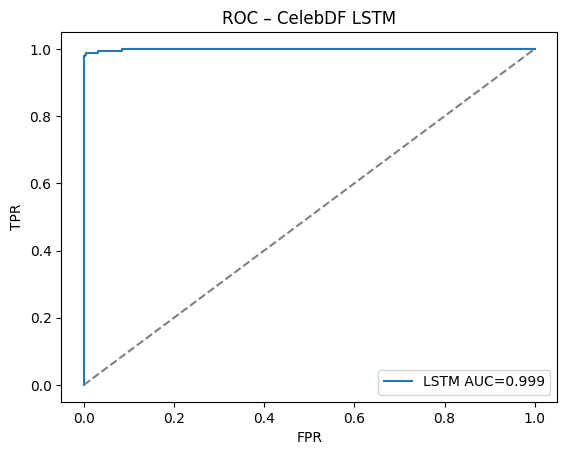

In [9]:
# ---------------------------
# 6) Test & save ROC/metrics
# ---------------------------
test_ds = CelebDFSeqDataset(
    root_dir="/kaggle/input/celebdfv2/crop/Test",
    split="Test",
    base_model=base_model,
    transform=transform,
    max_len=40
)
test_loader = DataLoader(test_ds, batch_size=16,
                         shuffle=False, num_workers=0)

lstm_model.eval()
preds, labs = [], []
with torch.no_grad():
    for seqs, lb in tqdm(test_loader, desc="Testing LSTM"):
        seqs = seqs.to(device)
        out  = lstm_model(seqs)
        pr   = torch.sigmoid(out).cpu().tolist()
        preds.extend(pr)
        labs.extend(lb.tolist())

# compute metrics
auc  = roc_auc_score(labs, preds)
binp = [1 if p>0.5 else 0 for p in preds]
f1   = f1_score(labs, binp)
acc  = accuracy_score(labs, binp)
print(f"Test → AUC: {auc:.4f}, F1: {f1:.4f}, Acc: {acc:.4f}")

# save metrics
json.dump({"auc":auc, "f1":f1, "acc":acc},
          open("metrics_celebdf_lstm.json","w"))

# ROC curve data
fpr, tpr, thr = roc_curve(labs, preds)
roc_data = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "thresholds": thr.tolist(),
    "auc": auc
}
json.dump(roc_data, open("roc_data_celebdf_lstm.json","w"), indent=2)
print("✅ Saved ROC data to roc_data_celebdf_lstm.json")

# optional: plot
plt.plot(fpr, tpr, label=f"LSTM AUC={auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – CelebDF LSTM")
plt.legend(); plt.show()

In [10]:
import os

def find_max_frames(root_dir, exts=('.jpg', '.png')):
    """
    Walks each immediate subfolder of root_dir, counts files ending with exts,
    and returns (subfolder_name, frame_count) for the folder with the maximum.
    """
    max_count = 0
    max_folder = None

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # count only files with the given extensions
        count = sum(
            1
            for f in os.listdir(folder_path)
            if f.lower().endswith(exts)
        )

        if count > max_count:
            max_count = count
            max_folder = folder

    return max_folder, max_count

# Example usage for Celeb‑DF:
celebd_root = "/kaggle/input/celebdfv2/crop/Train"
for label in ["real", "fake"]:
    path = os.path.join(celebd_root, label)
    folder, cnt = find_max_frames(path)
    print(f"Celeb‑DF Train/{label} → {folder!r} has the most frames: {cnt}")


Celeb‑DF Train/real → '00007' has the most frames: 92
Celeb‑DF Train/fake → 'id55_id49_0002' has the most frames: 85


In [11]:
import os
import json
import numpy as np

def folder_frame_stats(root_dir, exts=('.jpg','.png')):
    """
    For each immediate subfolder of root_dir, counts files ending with exts.
    Returns (max_count, max_folder, avg_count).
    """
    counts = []
    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path): 
            continue
        c = sum(1 for f in os.listdir(folder_path)
                if f.lower().endswith(exts))
        counts.append((folder, c))
    if not counts:
        return None, 0, 0.0
    # unpack
    folders, cs = zip(*counts)
    max_idx    = int(np.argmax(cs))
    max_folder = folders[max_idx]
    max_count  = cs[max_idx]
    avg_count  = float(np.mean(cs))
    return max_folder, max_count, avg_count

# --- Celeb‑DF Train & Test ---
for split in ["Train", "Test"]:
    root = f"/kaggle/input/celebdfv2/crop/{split}"
    for label in ["real", "fake"]:
        path = os.path.join(root, label)
        mf, mc, ac = folder_frame_stats(path)
        print(f"CelebDF {split}/{label}:  max={mc} @ '{mf}',   avg={ac:.1f}")

CelebDF Train/real:  max=92 @ '00007',   avg=41.4
CelebDF Train/fake:  max=85 @ 'id55_id49_0002',   avg=38.4
CelebDF Test/real:  max=73 @ '00275',   avg=40.2
CelebDF Test/fake:  max=85 @ 'id55_id57_0002',   avg=38.6
